In [1]:
import os
import sys
import git
import pathlib

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 

PROJ_ROOT_PATH = pathlib.Path(git.Repo('.', search_parent_directories=True).working_tree_dir)
PROJ_ROOT =  str(PROJ_ROOT_PATH)
if PROJ_ROOT not in sys.path:
    sys.path.append(PROJ_ROOT)

print(f"Project Root Directory: {PROJ_ROOT}")

Project Root Directory: /repos/drl_csense


In [2]:
import numpy as np
import matplotlib.pyplot as plt

In [3]:
import scipy.fftpack as spfft
from sklearn.linear_model import Lasso

In [4]:
import gymnasium as gym

In [5]:
from lib.folder_paths import makeget_logging_dir
from lib.env_utils import AtariWrapper_NoisyFrame, AtariWrapper_Compressed, make_atari_env_Custom_VecFrameStack

In [6]:
from lib.folder_paths import get_exp_name_tag, deconstruct_exp_name

In [7]:
import imageio
import ipyplot

In [8]:
def idct2(x):
        return spfft.idct(spfft.idct(x.T, norm='ortho', axis=0).T, norm='ortho', axis=0)

alpha=1E-5
max_iter=1E5
lasso = Lasso(alpha=alpha, max_iter=int(max_iter), warm_start=True, selection="random")

In [9]:
def reconstruct_frame(frame):
    ny, nx = frame.shape
    A = np.kron(
        spfft.idct(np.identity(nx), norm='ortho', axis=0),
        spfft.idct(np.identity(ny), norm='ortho', axis=0)
        )

    flat_frame = frame.T.reshape(-1,1)
    idx_nonzero = np.where(flat_frame != 0)[0]

    # compressed sample
    b = flat_frame[idx_nonzero]
    # compression matrix @ transform matrix
    Ac = A[idx_nonzero,:]

    # LASSO optimization
    lasso.fit(Ac, b)

    # Reconstruct frame
    Xat = np.array(lasso.coef_).reshape(nx, ny).T # stack columns

    # Get the reconstructed frame
    Xa = idct2(Xat)

    return Xa

In [10]:
def draw_frames(frameblock, filename):
    fig_width = 30
    fig_height = 30
    # nrows = 4
    # ncols = 4
    no_of_frames = frameblock.shape[0]
    ncols = int(np.ceil(np.sqrt(no_of_frames)))
    nrows = int(np.ceil(no_of_frames/ncols))
    fig, axes = plt.subplots(nrows=nrows, 
                             ncols=ncols,
                             figsize=[fig_width,fig_height],
                             layout='constrained',
                             sharex=True,
                             sharey=True)
    for row in range(nrows):
        for col in range(ncols):
            ax = axes[row][col]
            ax.axis("off")
            frame_no = row*ncols + col
            if frame_no < no_of_frames:
                ax.imshow(frameblock[frame_no], cmap="gray")
                ax.set_title(f'frame: {frame_no}')
    plt.savefig(filename, bbox_inches='tight')

In [11]:
env_id = "BreakoutNoFrameskip-v4"
exp_param_type = "noisy"
exp_param_value = 0.0
run_no = 0
model_type = "best"
eval_param_type = exp_param_type

In [12]:
eval_param_value = 0.1

# Get names and tags of experiment
exp_name, exp_metaname, exp_tag = get_exp_name_tag(env_id, exp_param_type, exp_param_value)

# Get directories
models_dir, log_dir, gif_dir, image_dir = makeget_logging_dir(exp_name)

# Load gif file
obs_gif_file = f"{gif_dir}/{exp_name}-run_{run_no}--eval_{model_type}-{eval_param_type}_{eval_param_value}--obs.gif"

obs_gif_frames = imageio.mimread(obs_gif_file)

In [13]:
obs_gif_frames_np = np.array(obs_gif_frames)

In [14]:
obs_gif_frames_single_layer = obs_gif_frames_np[:,:,:,1]

In [15]:
gif_block_size = 84
gif_block = obs_gif_frames_single_layer[:gif_block_size]

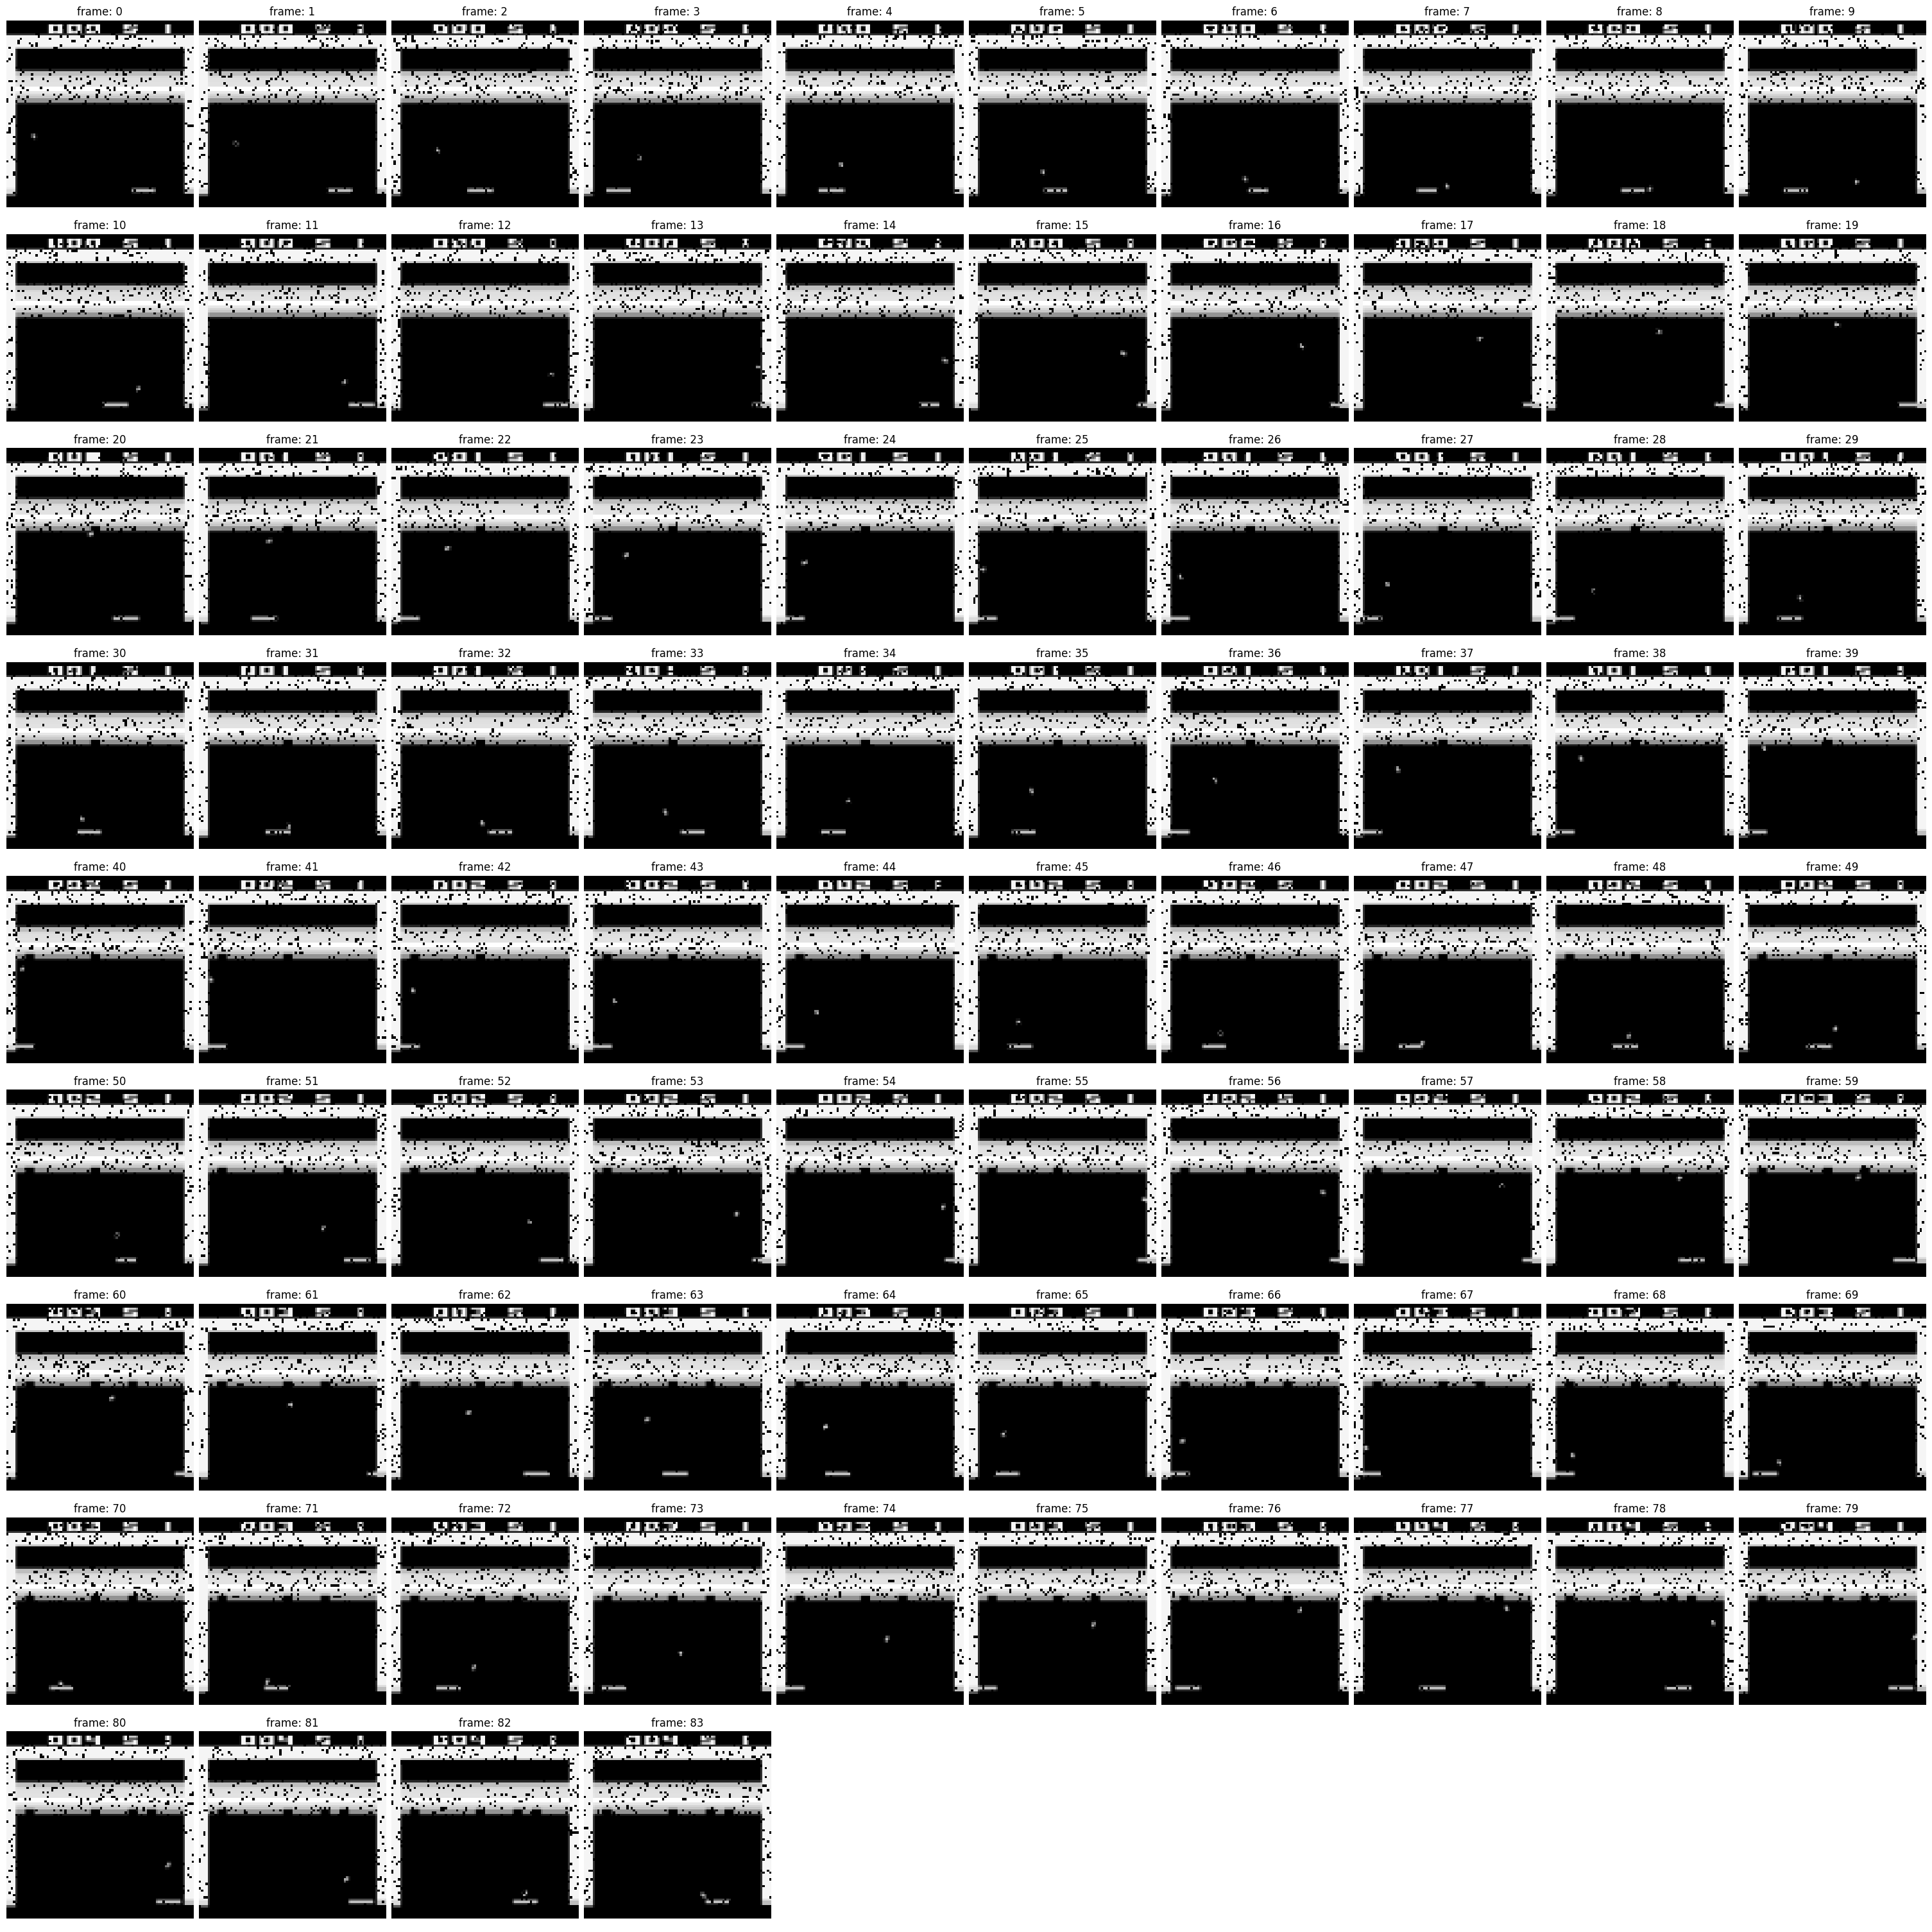

In [16]:
draw_frames(gif_block, f"original_noisy_{int(eval_param_value*100)}")

In [17]:
# ycs_timeframe_LIST = []
# for i in range(84):
#     ytimeframe = gif_block[:,:,i]
#     if np.sum(np.abs(ytimeframe)) > 0.0:
#         ycs_timeframe = reconstruct_frame(ytimeframe)
#     else:
#         ycs_timeframe = ytimeframe
#     ycs_timeframe_LIST.append(ycs_timeframe)

In [18]:
# ycs_gif = np.array(ycs_timeframe_LIST)
# ycs_gif_reshaped = np.moveaxis(ycs_gif, 0 , 2)

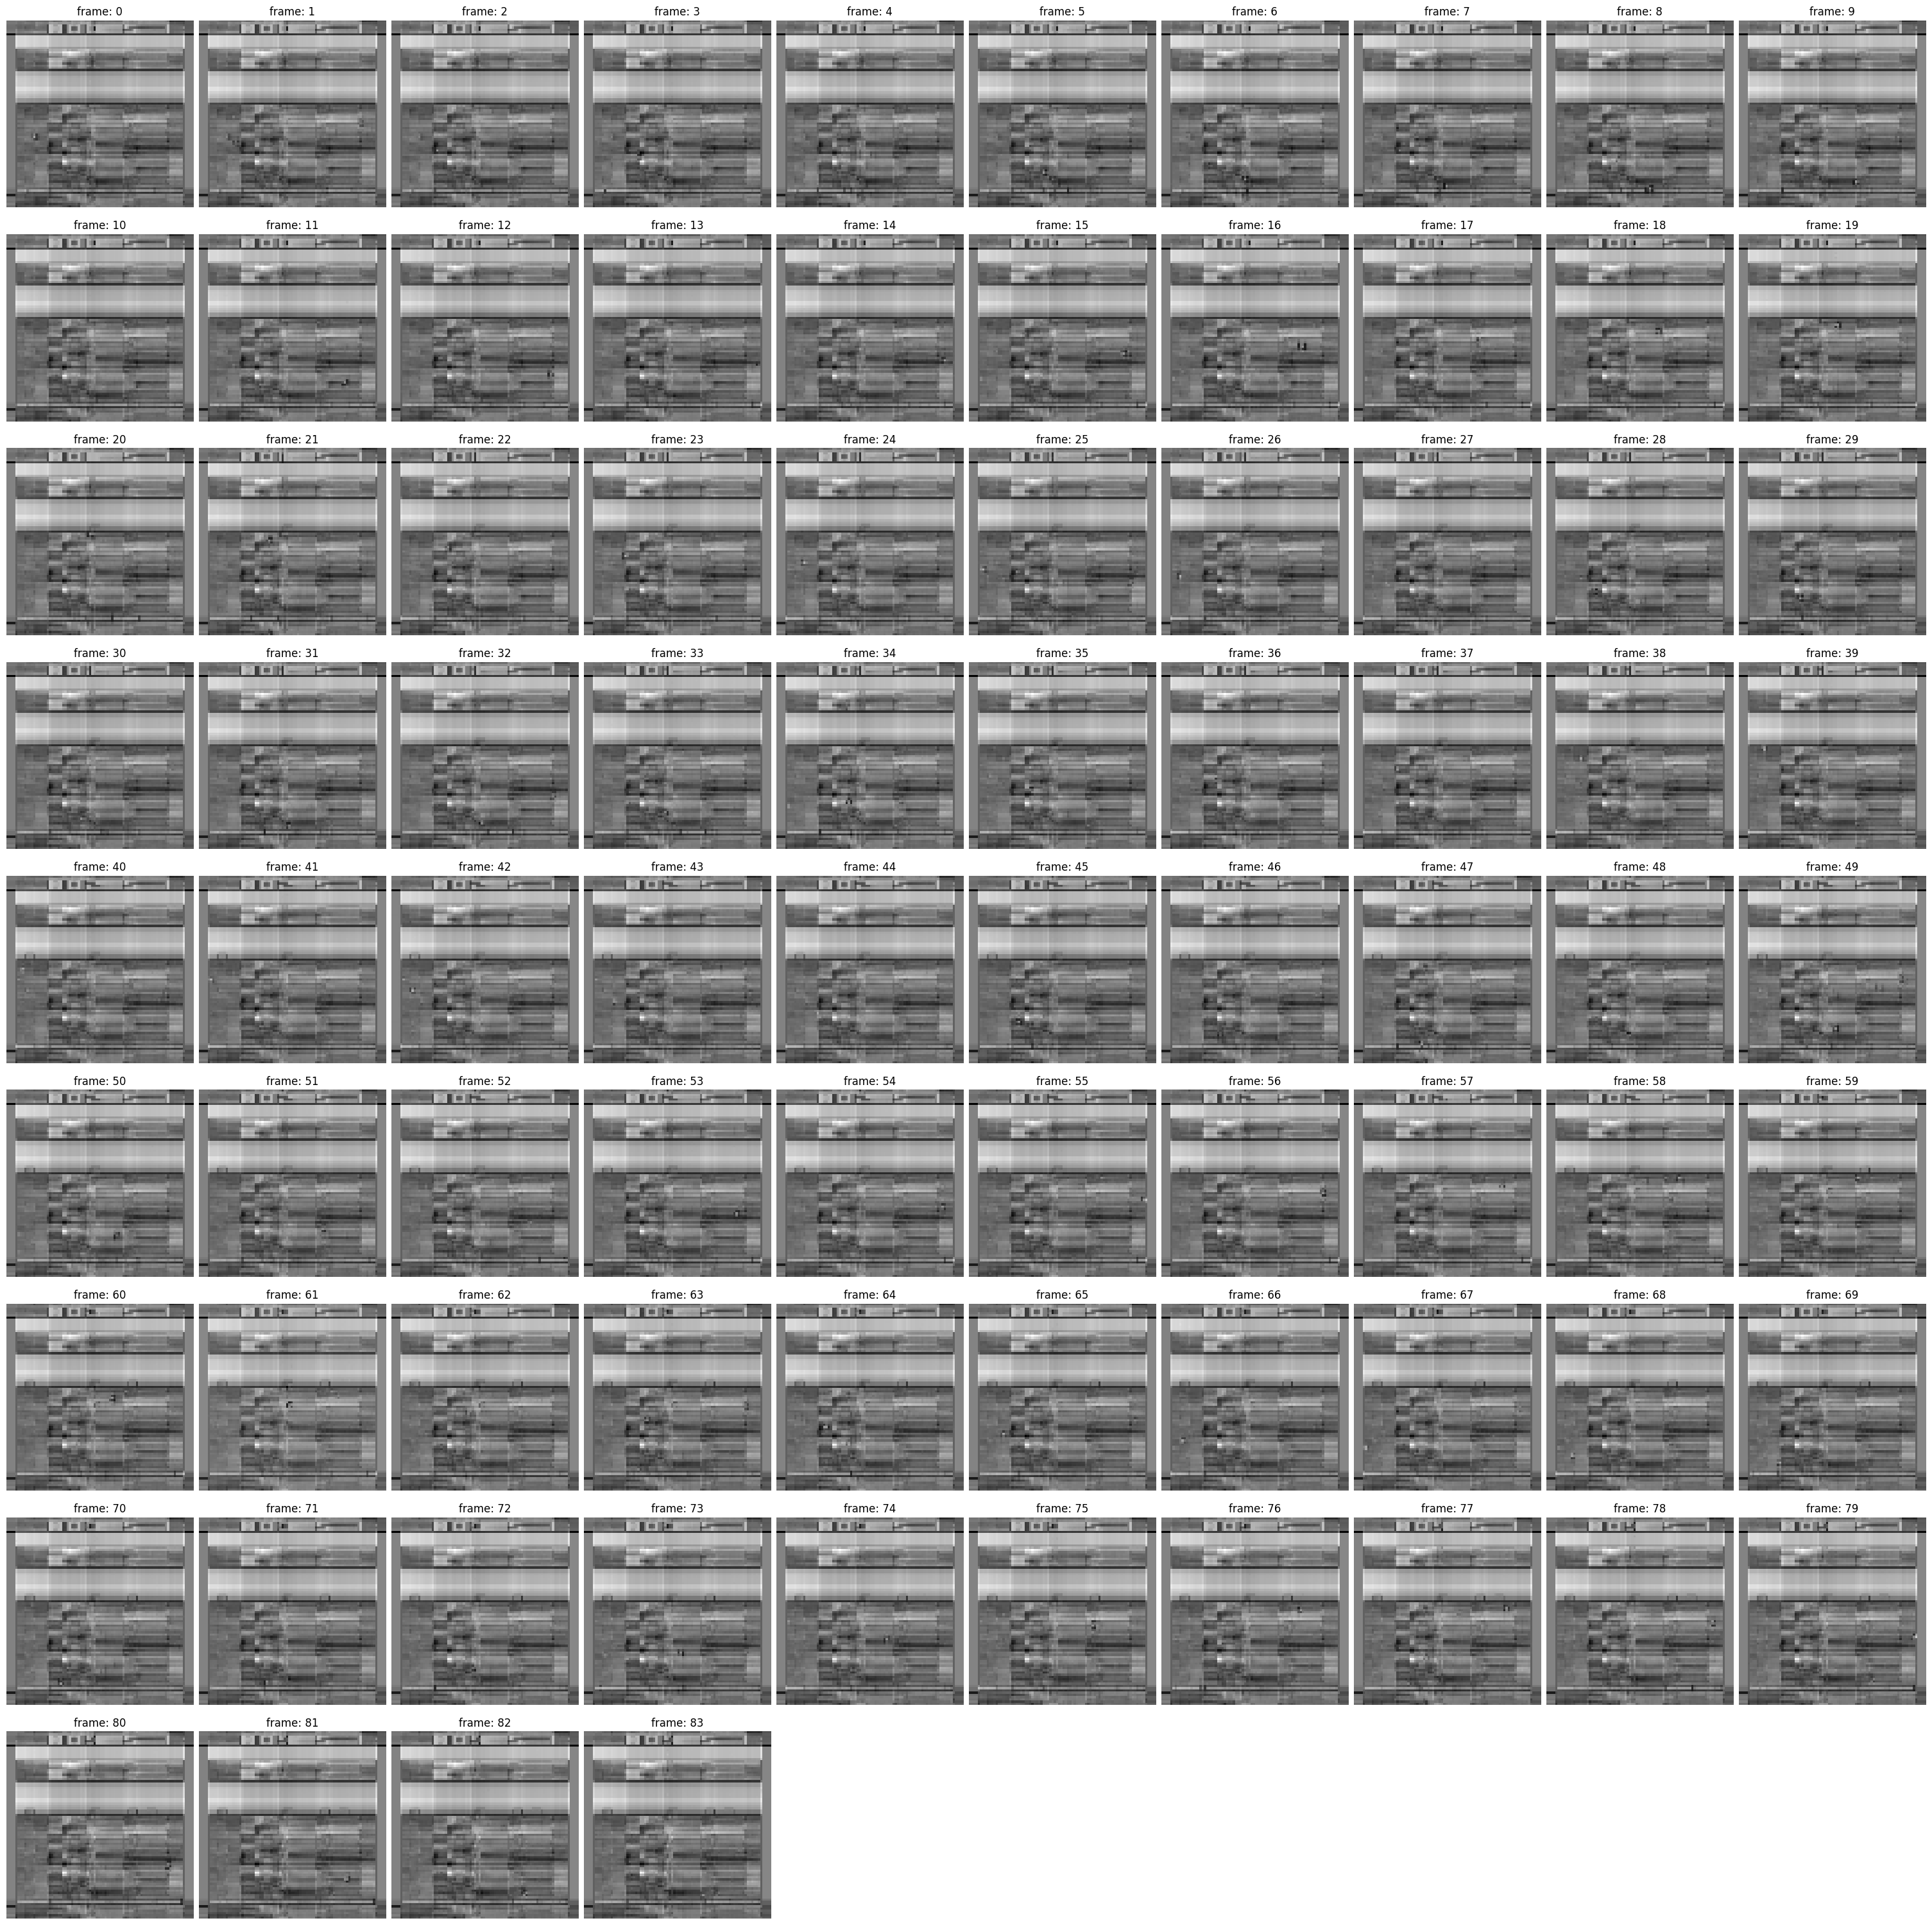

In [19]:
# draw_frames(ycs_gif_reshaped, f"ycs_noisy_{int(eval_param_value*100)}")

In [ ]:
xcs_timeframe_LIST = []
for i in range(84):
    xtimeframe = gif_block[:,i,:]
    if np.sum(np.abs(xtimeframe)) > 0.0:
        xcs_timeframe = reconstruct_frame(xtimeframe)
    else:
        xcs_timeframe = xtimeframe
    xcs_timeframe_LIST.append(xcs_timeframe)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.229e-22, tolerance: 0.000e+00
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 0.000e+00, tolerance: 0.000e+00
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 0.000e+00, tolerance: 0.000e

In [ ]:
xcs_gif = np.array(xcs_timeframe_LIST)
xcs_gif_reshaped = np.moveaxis(xcs_gif, 0 , 1)
draw_frames(xcs_gif_reshaped, f"xcs_noisy_{int(eval_param_value*100)}")